# Imports

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.patches as mpatches

# Dataset Exploration

In [2]:
# Read the CSV file into a dataframe
import pandas as pd

DATA = pd.read_csv("DSL-StrongPasswordData.csv")
SUBJECTS = DATA["subject"].unique()
# Display information about the dataset
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          20400 non-null  object 
 1   sessionIndex     20400 non-null  int64  
 2   rep              20400 non-null  int64  
 3   H.period         20400 non-null  float64
 4   DD.period.t      20400 non-null  float64
 5   UD.period.t      20400 non-null  float64
 6   H.t              20400 non-null  float64
 7   DD.t.i           20400 non-null  float64
 8   UD.t.i           20400 non-null  float64
 9   H.i              20400 non-null  float64
 10  DD.i.e           20400 non-null  float64
 11  UD.i.e           20400 non-null  float64
 12  H.e              20400 non-null  float64
 13  DD.e.five        20400 non-null  float64
 14  UD.e.five        20400 non-null  float64
 15  H.five           20400 non-null  float64
 16  DD.five.Shift.r  20400 non-null  float64
 17  UD.five.Shif

In [3]:
# Display descriptive statistics of the dataframe
DATA.describe()

,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,DD.i.e,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,...,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,4.500000,25.500000,0.093379,0.264148,0.170769,0.085727,0.169085,0.083358,0.081565,0.159372,...,0.106259,0.150670,0.044411,0.089899,0.202630,0.112731,0.095589,0.321847,0.226259,0.088306
std,2.291344,14.431223,0.029626,0.220534,0.226836,0.027424,0.123546,0.125755,0.026887,0.226928,...,0.038828,0.107422,0.105197,0.030738,0.150191,0.159571,0.028348,0.225389,0.230759,0.027452
min,1.000000,1.000000,0.001400,0.018700,-0.235800,0.009300,0.001100,-0.162100,0.003200,0.001400,...,0.004000,0.001100,-0.235500,0.003700,0.001300,-0.175800,0.003700,0.008300,-0.124500,0.002900
25%,2.750000,13.000000,0.074400,0.146900,0.049800,0.066000,0.113600,0.027200,0.062000,0.089300,...,0.082100,0.096100,-0.009000,0.067300,0.127600,0.023500,0.077400,0.210000,0.114100,0.069900
50%,4.500000,25.500000,0.089500,0.205950,0.108700,0.081000,0.140400,0.057800,0.077100,0.120900,...,0.101900,0.125000,0.022700,0.085300,0.172500,0.095500,0.093700,0.263000,0.160300,0.085500
75%,6.250000,38.000000,0.107900,0.306450,0.212400,0.099800,0.183900,0.096400,0.096900,0.173100,...,0.122300,0.174600,0.068900,0.107900,0.228800,0.145700,0.111100,0.350200,0.255100,0.103700
max,8.000000,50.000000,0.376100,12.506100,12.451700,0.241100,4.919700,4.799900,0.331200,25.987300,...,2.035300,3.327800,2.524200,0.357700,4.025200,3.978200,0.340700,5.883600,5.836400,0.265100


<Axes: ylabel='count'>

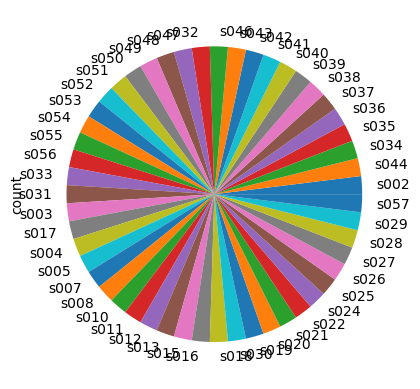

In [4]:
# Plotting the pie chart for the 'subject' column
# Count the number of occurrences of each unique value in the 'subject' column
# Plot a pie chart to visualize the distribution of subjects
DATA["subject"].value_counts().plot(kind="pie")

In [5]:
# Get the unique user IDs from the 'subject' column
USER_IDS = DATA["subject"].unique()

# Randomly select 6 user IDs from the unique user IDs
SAMPLE_USERS = ["s005", "s016", "s018", "s026", "s043", "s057"]
# Filter the dataframe to include only the rows with the selected user IDs
SAMPLE_CMU_KEYSTROKE_DF = DATA[DATA["subject"].isin(SAMPLE_USERS)]

# Display the top rows of the filtered dataframe
print(SAMPLE_CMU_KEYSTROKE_DF.head())

     subject  sessionIndex  rep  H.period  DD.period.t  UD.period.t     H.t  \
1200    s005             1    1    0.0729       0.2393       0.1664  0.1254   
1201    s005             1    2    0.0721       0.9983       0.9262  0.1077   
1202    s005             1    3    0.0631       1.2671       1.2040  0.1362   
1203    s005             1    4    0.1040       0.6528       0.5488  0.1288   
1204    s005             1    5    0.0837       0.6212       0.5375  0.1090   

      DD.t.i  UD.t.i     H.i  ...     H.a  DD.a.n  UD.a.n     H.n  DD.n.l  \
1200  0.3416  0.2162  0.0853  ...  0.1840  0.5625  0.3785  0.0747  0.3779   
1201  0.3803  0.2726  0.0752  ...  0.1570  0.2756  0.1186  0.0982  0.5534   
1202  0.3254  0.1892  0.0792  ...  0.1787  0.2854  0.1067  0.0483  1.0708   
1203  0.4310  0.3022  0.0977  ...  0.1399  0.3305  0.1906  0.0803  0.4286   
1204  0.4267  0.3177  0.0924  ...  0.1280  0.2405  0.1125  0.0869  0.4389   

      UD.n.l     H.l  DD.l.Return  UD.l.Return  H.Return  
120

In [6]:
# Function to draw the keystroke feature graph
import matplotlib.pyplot as plt
import seaborn as sns

def draw_graph(dataframe, figname):
    # Set the color palette
    sns.set_palette(sns.color_palette("Dark2"))

    # Plot the line graph
    sns.lineplot(x="keystroke", y="value", hue="subject", data=dataframe)

    # Rotate the x-axis labels
    for label in plt.xticks()[1]:
        label.set_rotation(45)

    # Set the x-axis label
    plt.xlabel("Keystroke")

    # Set the y-axis label
    plt.ylabel("Average Duration (ms)")

    # Set the title
    plt.title("Average Duration of Keystrokes")

    # Save the figure
    plt.savefig(figname + ".png")

    # Show the graph
    plt.show()

In [7]:
# Drop the 'sessionIndex' and 'rep' columns from the 'sample_cmu_keystroke_df' dataframe
SAMPLE_CMU_KEYSTROKE_DF = SAMPLE_CMU_KEYSTROKE_DF.drop(["sessionIndex", "rep"], axis=1)

# Create three subsets of the sample dataset
# Each subset consists of either DD, UD, or H features

# Subset for DD features
DF_DD = SAMPLE_CMU_KEYSTROKE_DF[
    [col for col in SAMPLE_CMU_KEYSTROKE_DF.columns if "DD" in col or col == "subject"]
]


# Subset for UD features
DF_UD = SAMPLE_CMU_KEYSTROKE_DF[
    [col for col in SAMPLE_CMU_KEYSTROKE_DF.columns if "UD" in col or col == "subject"]
]


# Subset for H features
DF_H = SAMPLE_CMU_KEYSTROKE_DF[
    [col for col in SAMPLE_CMU_KEYSTROKE_DF.columns if "H" in col or col == "subject"]
]

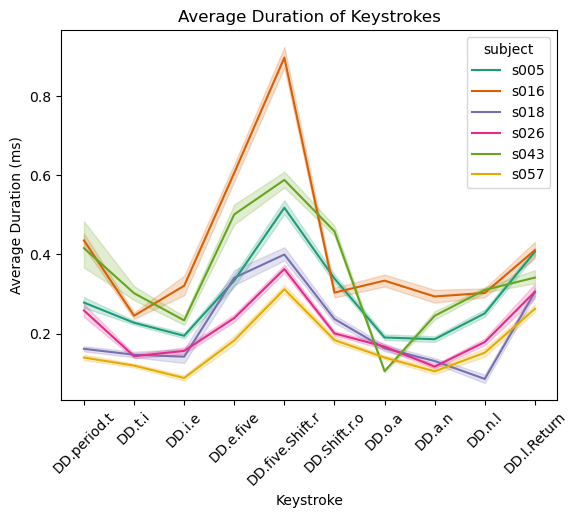

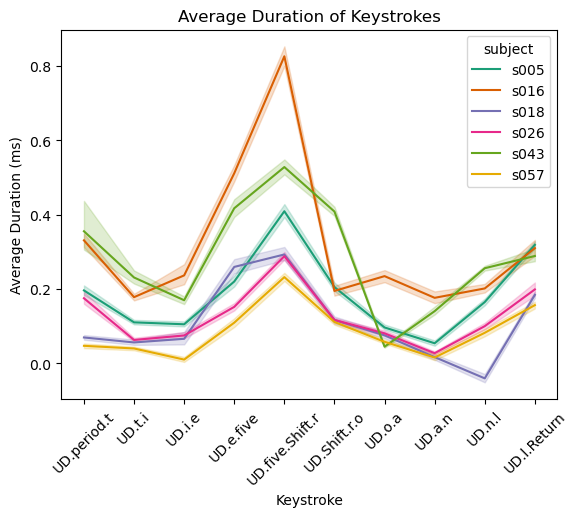

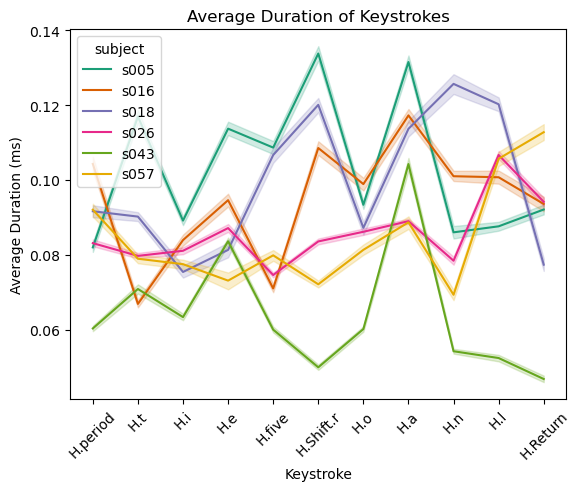

In [8]:
# Reshape the 'df_DD', 'df_UD', and 'df_H' dataframes using the 'melt' function
import pandas as pd

DF_DD = pd.melt(DF_DD, id_vars="subject", var_name="keystroke")
DF_UD = pd.melt(DF_UD, id_vars="subject", var_name="keystroke")
DF_H = pd.melt(DF_H, id_vars="subject", var_name="keystroke")

# Draw the graph for DD feature
draw_graph(DF_DD, "DD_figure.png")

# Draw the graph for UD feature
draw_graph(DF_UD, "UD_figure.png")

# Draw the graph for H feature
draw_graph(DF_H, "H_figure.png")

# Model Implementation

## Functions

In [9]:
import numpy as np


def evaluate(alluser_scores, allimposter_scores):
    """
    Function to evaluate Equal Error Rate (EER), Area Under the Curve (AUC) and Accuracy (ACC)

    Parameters:
    alluser_scores (array-like): Array of scores for genuine users
    allimposter_scores (array-like): Array of scores for imposters

    Returns:
    EER (float): Equal Error Rate
    AUC (float): Area Under the Curve
    ACC (float): Accuracy
    """
    labels = [0] * len(alluser_scores) + [1] * len(allimposter_scores)
    temp_scores = np.append(alluser_scores, allimposter_scores)

    fpr, tpr, thresholds = roc_curve(labels, temp_scores, drop_intermediate=False, pos_label=1)
    fnr = 1 - tpr
    thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)

    auc = roc_auc_score(labels, temp_scores)

    temp_scores[temp_scores >= 0.5] = 1
    temp_scores[temp_scores < 0.5] = 0

    acc = accuracy_score(labels, temp_scores)
    return eer, auc, acc

In [10]:
import numpy as np


def evaluate_classifier(clf):
    """
    Function to evaluate the classifier

    Parameters:
    clf (object): Classifier object

    Returns:
    allUserScores (array-like): Array of scores for genuine users
    allImposterScores (array-like): Array of scores for imposters
    res (dict): Dictionary of evaluation results
    """
    data = pd.read_csv("DSL-StrongPasswordData.csv")
    subjects = DATA["subject"].unique()
    
    res = {}
    aucs = []
    eers = []
    accs = []
    all_user_scores = np.array([])
    all_imposter_scores = np.array([])
    for subject in subjects:
        genuine_user_data = data.loc[data["subject"] == subject, "H.period":]
        imposter_data = data.loc[data["subject"] != subject, :]

        train = genuine_user_data[:200].values

        test_genuine = genuine_user_data[200:]
        test_genuine = test_genuine.values

        test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":]
        test_imposter = test_imposter.values

        clf.fit(train)

        user_scores = clf.predict_proba(test_genuine)
        imposter_scores = clf.predict_proba(test_imposter)
    
        (eer, auc, acc) = evaluate(user_scores[:, 1], imposter_scores[:, 1])
    
        eers.append(eer)
        aucs.append(auc)
        accs.append(acc)

        all_user_scores = np.append(all_user_scores, user_scores[:, 1])
        all_imposter_scores = np.append(all_imposter_scores, imposter_scores[:, 1])
    
    res["EER"] = round(np.mean(eers) * 100, 2)
    res["ACC"] = round(np.mean(accs) * 100, 2)
    res["AUC"] = round(np.mean(aucs) * 100, 2)
    
    return all_user_scores, all_imposter_scores, res

## Model Definition and Training

In [11]:
# detector list for LSCP
import numpy as np

from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.lscp import LSCP
from pyod.models.lof import LOF
from pyod.models.lmdd import LMDD
from pyod.models.knn import KNN
from pyod.models.kde import KDE
from pyod.models.inne import INNE
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.gmm import GMM
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.cblof import CBLOF
from pyod.models.abod import ABOD
DETECTOR_LIST = [
    LOF(n_neighbors=5),  # Local Outlier Factor with 5 neighbors
    LOF(n_neighbors=10),  # Local Outlier Factor with 10 neighbors
    LOF(n_neighbors=15),  # Local Outlier Factor with 15 neighbors
    LOF(n_neighbors=20),  # Local Outlier Factor with 20 neighbors
    LOF(n_neighbors=25),  # Local Outlier Factor with 25 neighbors
    LOF(n_neighbors=30),  # Local Outlier Factor with 30 neighbors
    LOF(n_neighbors=35),  # Local Outlier Factor with 35 neighbors
    LOF(n_neighbors=40),  # Local Outlier Factor with 40 neighbors
    LOF(n_neighbors=45),  # Local Outlier Factor with 45 neighbors
    LOF(n_neighbors=50),  # Local Outlier Factor with 50 neighbors
]

RANDOM_STATE = np.random.RandomState(42)
OUTLIERS_FRACTION = 0.1

# Define classifiers dictionary with comments
CLASSIFIERS = {
    "Linear Models": {
        "Principal Component Analysis (PCA)": PCA(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # PCA with specified contamination and random state
        "One-class SVM (OCSVM)": OCSVM(
            contamination=OUTLIERS_FRACTION
        ),  # One-class SVM with specified contamination
        "LMDD": LMDD(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # LMDD with specified contamination
    },
    "Proximity-Based Models": {
        "Histogram-base Outlier Detection (HBOS)": HBOS(
            contamination=OUTLIERS_FRACTION
        ),  # HBOS with specified contamination
        "Cluster-based Local Outlier Factor (CBLOF)": CBLOF(
            contamination=OUTLIERS_FRACTION,
            check_estimator=False,
            n_clusters=8,
            random_state=RANDOM_STATE,
        ),  # CBLOF with specified contamination, number of clusters, and random state
        "K Nearest Neighbors (KNN)": KNN(
            n_neighbors=5, contamination=OUTLIERS_FRACTION
        ),  # KNN with specified contamination
        "Average KNN": KNN(
            method="mean", contamination=OUTLIERS_FRACTION
        ),  # KNN with mean method and specified contamination
        "Local Outlier Factor (LOF)": LOF(
            n_neighbors=35, contamination=OUTLIERS_FRACTION
        ),  # LOF with specified number of neighbors and contamination
    },
    "Probabilistic Models": {
        "Angle-based Outlier Detector (ABOD)": ABOD(
            contamination=OUTLIERS_FRACTION
        ),  # ABOD with specified contamination
        "Kernel Density Estimation": KDE(
            contamination=OUTLIERS_FRACTION
        ),  # KDE with specified contamination
        "Gaussian Mixture Model": GMM(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # GMM with specified contamination
    },
    "Ensembles and Combination Frameworks": {
        "Isolation Forest": IForest(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # Isolation Forest with specified contamination and random state
        "Feature Bagging": FeatureBagging(
            LOF(n_neighbors=35), contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # Feature Bagging with LOF, specified contamination, and random state
        "Locally Selective Combination (LSCP)": LSCP(
            DETECTOR_LIST, contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # LSCP with detector list, specified contamination, and random state
        "INNE": INNE(
            contamination=OUTLIERS_FRACTION, random_state=RANDOM_STATE
        ),  # INNE with specified contamination
},}

In [12]:
import numpy as np

RESULTS = {}
FIGURES = {}
# Loop through the classifiers dictionary
for i, (group_name, group) in enumerate(CLASSIFIERS.items()):
    print(str(i + 1) + "-) " + group_name)
    FIGURES[group_name] = {}
    # Loop through the classifiers within each group
    for j, (clf_name, clf) in enumerate(group.items()):
        print("     ", str(j + 1) + "-) ", "fitting", clf_name)

        # Evaluate the classifier and get the scores
        allUserScores, allImposterScores, res = evaluate_classifier(clf)
        RESULTS[clf_name] = res
        # Combine the user and imposter scores
        allScores = np.append(allUserScores, allImposterScores)

        # Create labels for the scores
        LABELS = [0] * len(allUserScores) + [1] * len(allImposterScores)

        # Calculate the ROC curve
        fpr, tpr, _ = roc_curve(LABELS, allScores)
        FIGURES[group_name][clf_name] = {"fpr": fpr, "tpr": tpr}

1-) Linear Models
      1-)  fitting Principal Component Analysis (PCA)
      2-)  fitting One-class SVM (OCSVM)
      3-)  fitting LMDD
2-) Proximity-Based Models
      1-)  fitting Histogram-base Outlier Detection (HBOS)
      2-)  fitting Cluster-based Local Outlier Factor (CBLOF)
      3-)  fitting K Nearest Neighbors (KNN)
      4-)  fitting Average KNN
      5-)  fitting Local Outlier Factor (LOF)
3-) Probabilistic Models
      1-)  fitting Angle-based Outlier Detector (ABOD)
      2-)  fitting Kernel Density Estimation
      3-)  fitting Gaussian Mixture Model
4-) Ensembles and Combination Frameworks
      1-)  fitting Isolation Forest
      2-)  fitting Feature Bagging
      3-)  fitting Locally Selective Combination (LSCP)
      4-)  fitting INNE


# Results

## Equal Error Rate (EER), Area Under the Curve (AUC) and Accuracy (ACC)

In [13]:
# Concatenate the dictionaries in the 'results' dictionary and convert them to dataframes
import pandas as pd

DF = pd.concat(
    {k: pd.DataFrame.from_dict(v, "index") for k, v in RESULTS.copy().items()}, axis=0
).stack()

# Set the index names of the dataframe
DF.index.names = ["model", "type", "metric"]

# Unstack the 'type' column to create separate columns for each type
DF = DF.unstack(["type"])

In [14]:
# Sort the dataframe 'df' by the 'EER' column in ascending order
DF = DF.sort_values(by=["EER"], ascending=True)

# Display the sorted dataframe

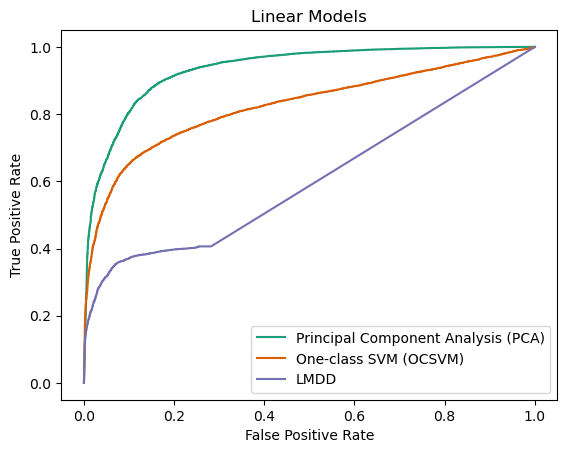

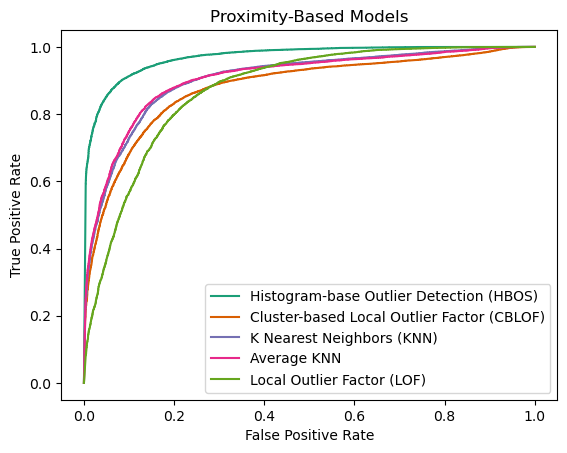

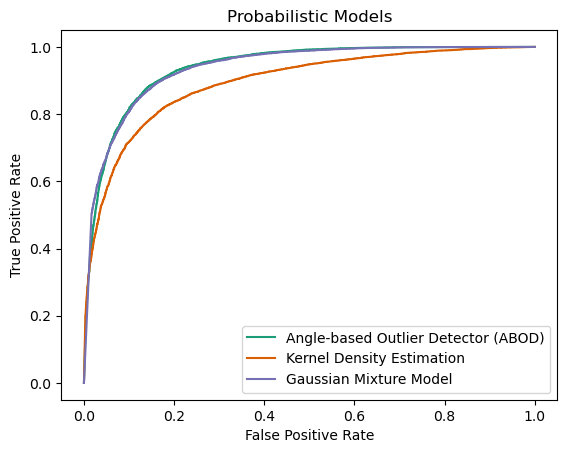

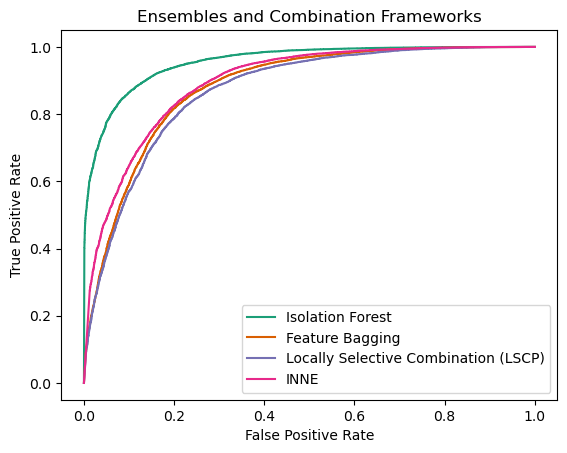

In [15]:
# Visualizing ROC Curves for Each Classifier Group
import matplotlib.pyplot as plt

# Loop through each group of classifiers
for i, (group_name, group) in enumerate(FIGURES.items()):

    # Create a new figure for each group
    plt.figure(i)

    # Set the title of the figure as the group name
    plt.title(group_name)

    # Set the x-axis label
    plt.xlabel("False Positive Rate")

    # Set the y-axis label
    plt.ylabel("True Positive Rate")

    # Loop through each classifier in the group
    for clf_name, res in group.items():

        # Get the false positive rate and true positive rate from the results
        fpr = res["fpr"]
        tpr = res["tpr"]

        # Plot the ROC curve for the classifier
        plt.plot(fpr, tpr, label=clf_name)

    # Add a legend to the plot
    plt.legend()

    # Save the plot as an image file
    plt.savefig("{}.png".format(group_name))

    # Show the plot
    plt.show()

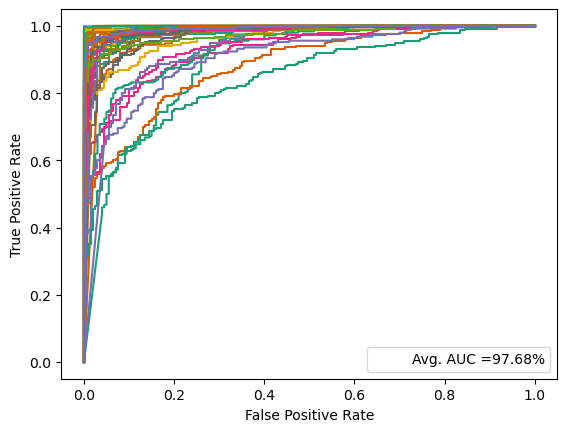

In [16]:
# Visualizing ROC Curves for Each Classifier Group
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store the AUC, EER, and accuracy scores
AUCS = []
EERS = []
ACCS = []
data = pd.read_csv("DSL-StrongPasswordData.csv")
subjects = data["subject"].unique()
# Loop through each subject
for subject in subjects:

    # Get the genuine user data for the current subject
    genuine_user_data = data.loc[data["subject"] == subject, "H.period":]

    # Get the imposter data for all subjects except the current subject
    imposter_data = data.loc[data["subject"] != subject, :]

    # Split the genuine user data into training and testing sets
    train = genuine_user_data[:200].values
    test_genuine = genuine_user_data[200:].values

    # Get the imposter data for testing
    test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":].values

    # Initialize and fit the HBOS classifier
    clf = HBOS(contamination=0.1)
    clf.fit(train)

    # Get the anomaly scores for the genuine user data and imposter data
    user_scores = clf.predict_proba(test_genuine)
    imposter_scores = clf.predict_proba(test_imposter)

    # Create the labels for the ROC curve

    # Create the scores for the ROC curve
    tempScores = np.append(user_scores[:, 1], imposter_scores[:, 1])

    # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
    labels = [0] * len(user_scores) + [1] * len(imposter_scores)

    fpr, tpr, thresholds = roc_curve(labels, tempScores, drop_intermediate=False, pos_label=1)

    # Calculate the false negative rate
    fnr = 1 - tpr

    # Calculate the equal error rate threshold and EER
    thresholds[np.nanargmin(np.absolute(fnr - fpr))]
    brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)

    # Plot the ROC curve
    plt.plot(fpr, tpr)

    # Calculate and store the AUC
    AUCS.append(roc_auc_score(labels, tempScores))

# Set the x-axis label
plt.xlabel("False Positive Rate")

# Set the y-axis label
plt.ylabel("True Positive Rate")

# Get the existing handles and labels for the legend
HANDLES, LABELS = plt.gca().get_legend_handles_labels()

# Create a patch with no color for the average AUC label
PATCH = mpatches.Patch(color="none", label="")

# Add the patch and label to the handles and labels lists
HANDLES.append(PATCH)
LABELS.append("Avg. AUC =" + str(round(np.mean(AUCS), 4) * 100) + "%")

# Add the legend to the plot
plt.legend(HANDLES, LABELS, loc="lower right")


# Save the plot as an image file
plt.savefig("HBOS.png")